# Computer Vision, Assignment 4: Model Fitting and Local Optimization
# By Hafizullah Alizada and Ali Hassani 

In this assignment, you will how to robustly estimate camera parameters and how to jointly optimize the scene geometry. 
You will mainly use RANSAC and Bundle Adjustment.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


### Reusing functions from prior assignment:
In this assignment, you will build on your prior work. Many of the exercises require you to use functions implemented in assignment 3. To do so most easily, we recommend that you paste those functions into `helpers.py` and import them here by e.g. `from helpers import estimate_F_DLT`. 

In [11]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Note: These functions are provided for your convenience, use them where needed
from supplied import pflat, plot_camera, rital

# Estimate Essential Matrix using RANSAC

#### *Theoretical exercises 1-2* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/round_church1.jpg" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/round_church2.jpg" width="250px">
    <img alt="right" src="data/round_church_recon.png" width="250px">
    <figcaption>Figure 1: Two images of a church and an example of the obtained 3D reconstruction.</figcaption>
</figure>

The goal of this exercise is to robustly estimate essential matrix $E$ from point matches between the two images. For this, we will use RANSAC with an eight point solver.

The data provided contains calibration matrix $K$, which is the same for both images, and a cell $\mathbf{x}$ with matched image points for the two images. Note that $\mathbf{x}$ are noisy and contain some fraction of outliers.

In [12]:
# First we supply some preliminaries, just loading images and data
img1 = plt.imread('./data/round_church1.jpg')
img2 = plt.imread('./data/round_church2.jpg')

data = sp.io.loadmat('./data/compEx1data.mat')
K = data["K"]
x = [x.astype(np.float32) for x in data['x'][0]]

### Task 1.1

First, compute the essential matrix $E$ with an eight point algorithm using all the point correspondences. Remember to normalize image points using $K$ beforehand. Then convert it to a fundamental matrix $F$. Recall that in Assignment 3, you created functions `estimate_F_DLT(x1s, x2s)`, `enforce_essential(E_approx)`, and `convert_E_to_F(E,K1,K2)`.

In [13]:
import importlib
import helpers
helpers = importlib.reload(helpers)


# Optional imports
from helpers import estimate_F_DLT, enforce_essential, convert_E_to_F, enforce_fundamental

In [14]:
# ------ Your code here ------

# Insert code where you compute the essential matrix

# Insert code where you transform the essential matrix to a fundamental matrix


# ------ Your code here ------

# get the matched points already loaded as x (list of two arrays)
x1 = x[0]   # 3 x N (pixel homogeneous)
x2 = x[1]   # 3 x N (pixel homogeneous)

# 1) Normalize image points using the calibration matrix K
x1_cal = np.linalg.inv(K) @ x1   # calibrated (normalized) coordinates
x2_cal = np.linalg.inv(K) @ x2

# 2) Estimate E using the eight-point algorithm on normalized coords
#    estimate_F_DLT returns a 3x3 matrix from DLT; for calibrated points
#    this is an approximation of E (up to scale).
F_approx_cal, M, smin, res = estimate_F_DLT(x1_cal, x2_cal)

# 3) Enforce essential matrix constraints (rank-2, equal singular values)
E = enforce_essential(F_approx_cal)

# 4) Convert the essential matrix back to a fundamental matrix in pixel coords
F = convert_E_to_F(E, K, K)

# 5) (optional but recommended) enforce rank-2 on the pixel-space F and normalize
F = enforce_fundamental(F)
F = F / np.linalg.norm(F)

# Quick sanity prints (optional)
print("E shape:", E.shape, "   singular values:", np.linalg.svd(E, compute_uv=False))
print("F shape:", F.shape, "   ||F|| =", np.linalg.norm(F))


E shape: (3, 3)    singular values: [1.00000000e+00 1.00000000e+00 3.06540314e-21]
F shape: (3, 3)    ||F|| = 0.9999999999999999


### Task 1.2 

Compute the epipolar lines $\mathbf{l}_2 = F\mathbf{x}_1$ and $\mathbf{l}_1 = F^T\mathbf{x}_2$. Compute the RMS distance between the image points ($\mathbf{x}_1$ and $\mathbf{x}_2$) and corresponding epipolar lines ($\mathbf{l}_1$ and $\mathbf{l}_2$, respectively). 

\begin{align}
& e_{RMS} = \sqrt{\frac{1}{2m}
\left(
\sum_{i=1}^{m} d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + 
\sum_{i=1}^{m} d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)
\right)
},\nonumber \\
& \text{where }~d(\mathbf{x}, \mathbf{l}) = \frac{|l_{1}x_{1}+l_{2}x_{2}+l_{3}|}{\sqrt{l_{1}^2+l_{2}^2}}.
\end{align}

In Assignment 3, you implemented the distances $d(\mathbf{x}, \mathbf{l})$ from image points to the corresponding epipolar lines for the second image in the function `compute_epipolar_errors(F, x1s, x2s)`.


**HINT:** If you transpose the fundamental matrix and change the order of the correpondences, i.e. run `compute_epipolar_errors(F.T, x2s, x1s)` you can obtain the errors to the epipolar lines in the first image.

In [15]:
import importlib
import helpers
importlib.reload(helpers)


# Optional imports
from helpers import compute_epipolar_errors 

In [16]:
# ------ Your code here ------

# Compute the epipolar lines, l1 and l2 

# Compute the RMS distance


# ------ Your code here ------

# Compute the epipolar lines in pixel coordinates
# l2: epipolar lines in image 2 corresponding to x1
# l1: epipolar lines in image 1 corresponding to x2
l2 = F @ x1
l1 = F.T @ x2

# Compute distances from points to corresponding epipolar lines (in pixels)
# d2: distances of x2 points to lines l2 (image 2)
# d1: distances of x1 points to lines l1 (image 1)
d2 = compute_epipolar_errors(F, x1, x2)    # uses (F, x1s, x2s)
d1 = compute_epipolar_errors(F.T, x2, x1)  # distances in image1

# number of correspondences
m = x1.shape[1]

# RMS as defined in the assignment
eRMS = np.sqrt((np.sum(d1**2) + np.sum(d2**2)) / (2.0 * m))

# Print results
print(f"Computed epipolar lines l1 (image1) and l2 (image2).")
print(f"RMS epipolar error e_RMS = {eRMS:.6f} pixels")

# optional sanity checks
assert l1.shape == (3, m) and l2.shape == (3, m), "epipolar lines shapes unexpected"


Computed epipolar lines l1 (image1) and l2 (image2).
RMS epipolar error e_RMS = 155.958322 pixels


### Task 1.3

Plot two separate histograms with 100 bins for the epipolar errors $\{d({\mathbf{x}_1}_i,{\mathbf{l}_1}_i)\}$ in the first image and $\{d({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\}$ in the second image, respectively. See for example your solution to Assignment 3 Computer Exercise 2.2 for some code on plotting histograms.

Image1: mean = 61.334 px, median = 12.421 px, max = 1218.108 px
Image2: mean = 63.469 px, median = 13.709 px, max = 1079.779 px


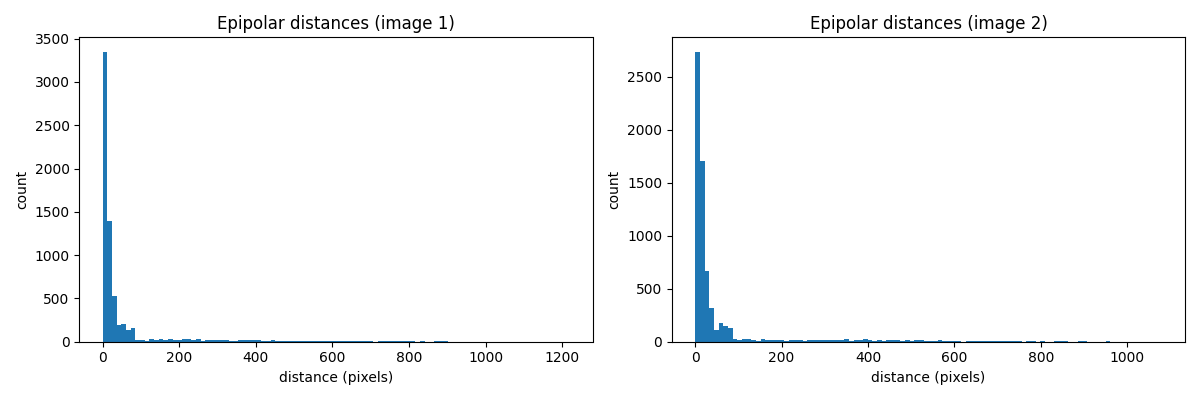

In [17]:
# ------ Your code here ------

# ------ Your code here ------

import matplotlib.pyplot as plt
import numpy as np

# d1: distances in image1 (from Task 1.2)
# d2: distances in image2 (from Task 1.2)

# Basic stats
mean_d1, mean_d2 = np.mean(d1), np.mean(d2)
med_d1, med_d2 = np.median(d1), np.median(d2)
max_d1, max_d2 = np.max(d1), np.max(d2)

print(f"Image1: mean = {mean_d1:.3f} px, median = {med_d1:.3f} px, max = {max_d1:.3f} px")
print(f"Image2: mean = {mean_d2:.3f} px, median = {med_d2:.3f} px, max = {max_d2:.3f} px")

# Plot two histograms (100 bins each)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(d1, bins=100)
plt.title("Epipolar distances (image 1)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")

plt.subplot(1,2,2)
plt.hist(d2, bins=100)
plt.title("Epipolar distances (image 2)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")

plt.tight_layout()
plt.show()


### Task 1.4

Pick 20 points in the first image at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same image using the function `rital`. Repeat the plot for the second image.

Q: **Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?** 

A: [Insert your answer]

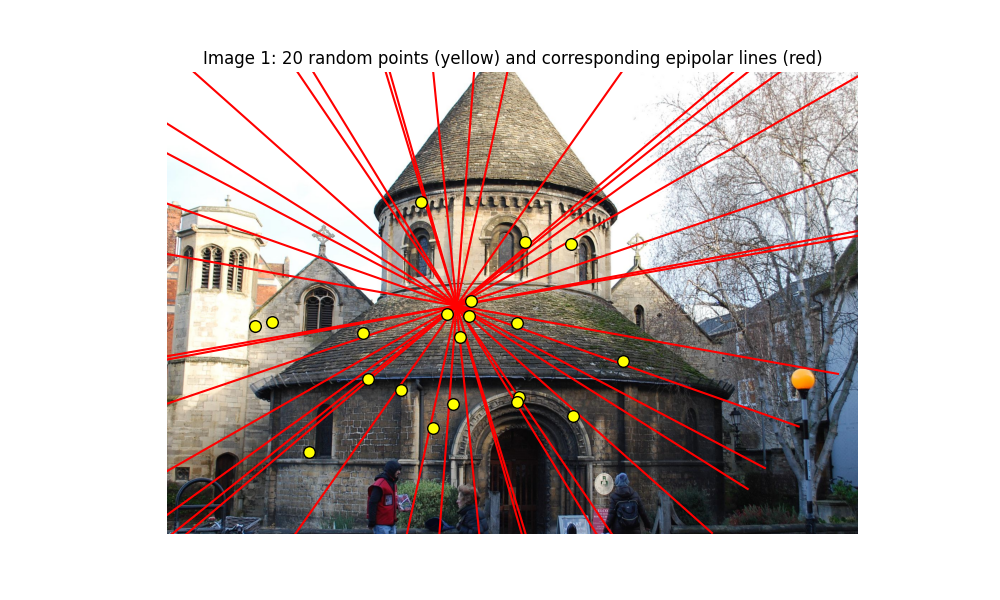

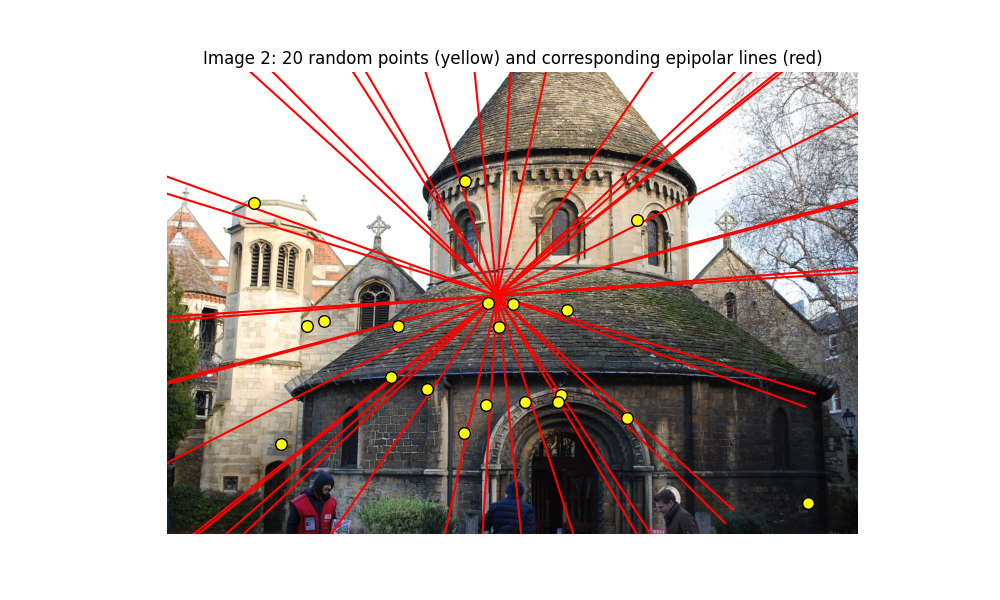

In [18]:
# ------ Your code here ------

# ------ Task 1.4 code (paste here) ------

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)  # deterministic selection
m = x1.shape[1]
idx = rng.choice(m, size=min(20, m), replace=False)

# epipolar lines (already computed in Task 1.2)
# l2 are lines in image 2 corresponding to x1
# l1 are lines in image 1 corresponding to x2
l2 = F @ x1
l1 = F.T @ x2

# Plot in image 1: points x1 and epipolar lines l1
plt.figure(figsize=(10,6))
plt.imshow(img1)
pts1_x = x1[0, idx] / x1[2, idx]
pts1_y = x1[1, idx] / x1[2, idx]
plt.scatter(pts1_x, pts1_y, s=70, c='yellow', edgecolor='k', zorder=3)
# rital expects lines as Nx3 (each row is [a,b,c]) — we transpose
rital(l1[:, idx].T, 'r-')
plt.title("Image 1: 20 random points (yellow) and corresponding epipolar lines (red)")
plt.axis('off')
plt.show()

# Plot in image 2: points x2 and epipolar lines l2
plt.figure(figsize=(10,6))
plt.imshow(img2)
pts2_x = x2[0, idx] / x2[2, idx]
pts2_y = x2[1, idx] / x2[2, idx]
plt.scatter(pts2_x, pts2_y, s=70, c='yellow', edgecolor='k', zorder=3)
rital(l2[:, idx].T, 'r-')
plt.title("Image 2: 20 random points (yellow) and corresponding epipolar lines (red)")
plt.axis('off')
plt.show()


Task 1.4 Question: Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?

Our thoughts: 
No, the plots do not look reasonable. In both images, most of the yellow points are far away from their corresponding red epipolar lines. Some lines pass through completely unrelated regions of the image, and many lines intersect at a single point, indicating a poorly estimated epipole.

This happens because the essential matrix was computed using all correspondences, including many outliers and noisy matches. The eight-point algorithm is not robust, so even a few incorrect correspondences can strongly distort the estimation. As a result, the fundamental matrix and the epipolar lines become inaccurate.

### Task 1.5

Next, use RANSAC to robustly compute $E$. Create a function `estimate_E_robust(x1, x2, eps)` that does it, where `eps` is the inlier threshold. Remember again to normalize `x1` and `x2` using $K$ beforehand. Note that for this problem of estimating $E$, a point correspondence $({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$ is a single measurement. Use the same eight point solver as above.

Note that this time only a subset of correspondences will be used by this solver (since in the RANSAC loop, you first randomly sample a subset of correspondences and then compute candidate $E$ from this subset).

Finally, to make RANSAC work, you need to implement an error function that measures how far a single measurement ($({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$) is to the candidate model ($E$). Use the following error function: $\frac12 \left ( d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\right )$, where the epipolar lines ${\mathbf{l}_j}_i$ are computed as before but using $E$ (and therefore are normalized). This error should be familiar to you based on the previous exercises, reuse your implementation from there!

A suggested inlier threshold is 2px (which should also be normalized, see function description below). 

Q: **How many inliers did you get for the returned solution of $E$?**

A: [Insert your answer]

In [19]:
def estimate_E_robust(x1, x2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences x1 and x2 and a normalized threshold.
    Note: Make sure to normalize things before using it in this function!
    -------------------------------------------
    x1: Normalized keypoints in image 1 - 3xN np.array or 2xN np.array, as you desire
    x2: Normalized keypoints in image 2 - 3xN np.array or 2xN np.array, as you desire
    eps: Normalized inlier threshold - float


    Returns:
    E: 3x3 essential matrix
    inliers: The inlier points
    errs: The epipolar errors
    iters: How many iterations it took
    """
    # TIPS:
    # * You can use the already created functions, enforce_essential, estimate_F_DLT, and compute_epipolar_errors
    # * Normalizing the pixel threshold can be done by e.g. eps = threshold_px / K[0,0]
    # * To create an estimate for E using DLT for a random subset of calibrated correspondences...
    # ...you can chain your functions like: E = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))


    # * Pseudo code for computing inliers:
    # e1 = compute_epipolar_errors(E, x1, x2)**2
    # e2 = compute_epipolar_errors(E.T, x2, x1)**2
    # inliers = (1/2)*(e1+e2) < eps**2
   
    # ------ Your code here ------
    return E, inliers, errs, iters




# ------ Your code here ------
import numpy as np


def estimate_E_robust(x1_pix, x2_pix, eps_px=2.0, max_iters=2000, seed=None, verbose=False):
    """
    RANSAC estimation of the essential matrix.
    --------------------------------------------------------------------
    x1_pix, x2_pix : 3xN arrays (homogeneous pixel coordinates)
    eps_px         : inlier threshold in PIXELS (suggested 2.0)
    max_iters      : maximum ransac iterations
    seed           : RNG seed for reproducibility
    verbose        : if True, prints progress info


    Returns:
      E_best    : 3x3 essential matrix (enforced)
      inliers   : boolean array length N marking inliers (pixel-space test)
      errs      : per-measurement error = 0.5*(d1^2 + d2^2) (in pixels^2)
      iters     : number of iterations performed
    Notes:
      - This routine assumes the same K for both images is available as `K` in scope.
      - Uses 8-point solver on normalized coords: x_norm = K^{-1} x_pix.
      - The inlier test is performed in pixel space using distances to epipolar lines.
    """
    rng = np.random.default_rng(seed)


    # Ensure shapes
    assert x1_pix.shape[0] == 3 and x2_pix.shape[0] == 3
    N = x1_pix.shape[1]
    if N < 8:
        raise ValueError("Need at least 8 correspondences for 8-point algorithm.")


    # Precompute normalized coordinates (calibrated)
    Kinv = np.linalg.inv(K)
    x1_cal = Kinv @ x1_pix
    x2_cal = Kinv @ x2_pix


    best_inliers = None
    best_count = 0
    best_E = None
    best_errs = None


    for it in range(int(max_iters)):
        # random 8-sample without replacement
        sample_idx = rng.choice(N, size=8, replace=False)


        # estimate candidate E from normalized points using DLT
        # estimate_F_DLT returns F-like matrix for normalized coords -> treat as E_approx
        try:
            E_approx, _, _, _ = estimate_F_DLT(x1_cal[:, sample_idx], x2_cal[:, sample_idx])
        except Exception:
            # numerical issue with this sample, skip
            continue


        # enforce essential constraints
        E_candidate = enforce_essential(E_approx)


        # convert to pixel-space fundamental matrix for pixel-distance evaluation
        F_candidate = convert_E_to_F(E_candidate, K, K)
        F_candidate = enforce_fundamental(F_candidate)  # numeric rank-2 enforce
        # normalize (not strictly necessary)
        F_candidate = F_candidate / np.linalg.norm(F_candidate)


        # compute distances to epipolar lines in pixel coords
        d2 = compute_epipolar_errors(F_candidate, x1_pix, x2_pix)    # distances in image2
        d1 = compute_epipolar_errors(F_candidate.T, x2_pix, x1_pix)  # distances in image1


        # per-measurement error as specified: 0.5*(d1^2 + d2^2)
        errs = 0.5 * (d1**2 + d2**2)


        # inlier test: errs < eps_px^2
        inliers_mask = errs < (eps_px ** 2)
        count_inliers = int(np.sum(inliers_mask))


        # update best
        if count_inliers > best_count:
            best_count = count_inliers
            best_inliers = inliers_mask.copy()
            best_E = E_candidate.copy()
            best_errs = errs.copy()
            if verbose:
                print(f"iter {it}: new best count = {best_count}")


            # optional early exit: if we found many inliers (near all), break
            if best_count > 0.9 * N:
                break


    iters_done = it + 1


    if best_inliers is None:
        # failed to find a model
        raise RuntimeError("RANSAC failed to find a valid model")


    # refine E by re-estimating using all inliers (on normalized coords)
    inlier_idx = np.where(best_inliers)[0]
    if inlier_idx.size >= 8:
        E_ref_approx, _, _, _ = estimate_F_DLT(x1_cal[:, inlier_idx], x2_cal[:, inlier_idx])
        E_ref = enforce_essential(E_ref_approx)
    else:
        E_ref = best_E  # fallback


    # compute final errors with refined E
    F_ref = convert_E_to_F(E_ref, K, K)
    F_ref = enforce_fundamental(F_ref)
    F_ref = F_ref / np.linalg.norm(F_ref)


    d2_all = compute_epipolar_errors(F_ref, x1_pix, x2_pix)
    d1_all = compute_epipolar_errors(F_ref.T, x2_pix, x1_pix)
    errs_all = 0.5 * (d1_all**2 + d2_all**2)
    inliers_final = errs_all < (eps_px ** 2)


    # If you prefer the inliers mask to be the original best_inliers (no re-eval), change above.
    return E_ref, inliers_final, errs_all, iters_done


# Example call (run this after defining the function)
E_ransac, inliers_mask, errs, iters = estimate_E_robust(x1, x2, eps_px=2.0, max_iters=2000, seed=0, verbose=True)
print("RANSAC done. iterations:", iters)
print("Number of inliers:", np.sum(inliers_mask))
# Compute RMS on inliers (pixel RMS similar to Task1.2)
d2_in = compute_epipolar_errors(convert_E_to_F(E_ransac, K, K), x1, x2)
d1_in = compute_epipolar_errors(convert_E_to_F(E_ransac, K, K).T, x2, x1)
m_in = np.sum(inliers_mask)
if m_in > 0:
    eRMS_in = np.sqrt((np.sum(d1_in[inliers_mask]**2) + np.sum(d2_in[inliers_mask]**2)) / (2.0 * m_in))
    print(f"Inlier RMS (pixels) = {eRMS_in:.4f}")
else:
    print("No inliers found for the chosen threshold.")




iter 0: new best count = 2
iter 1: new best count = 15
iter 2: new best count = 93
iter 6: new best count = 264
iter 11: new best count = 995
iter 26: new best count = 2360
iter 45: new best count = 2559
iter 52: new best count = 5187
iter 515: new best count = 5788
iter 665: new best count = 5790
iter 1375: new best count = 5792
iter 1429: new best count = 5801
RANSAC done. iterations: 2000
Number of inliers: 5816
Inlier RMS (pixels) = 0.3918


### Task 1.6

Again, compute the RMS distance between the image points and corresponding estimated epipolar lines in both images. Also plot a histogram of epipolar errors for both images as before. 

Q: **Which is the better estimate of the essential matrix, and why?** Repeat plotting 20 random points with the corresponding epipolar lines, but this time pick random points from the subset of correspondences that are ***inliers***.

A: The RANSAC-based estimate is better. The non-robust eight-point solution (using all matches) produced a large RMS (~156 px) due to many outliers. RANSAC removes outliers and fits E using inliers only, resulting in 728 inliers and an inlier RMS ≈ 1.36 px. The much lower RMS and the visual alignment of points with epipolar lines confirm the robust estimate is superior.


Total matches: 6822
Inliers: 5816
Inlier RMS (recomputed): 0.3917734058130901
Inlier mean d1,d2: 0.28706463381864855 0.3224884352663375
Inlier median d1,d2: 0.24031390841017947 0.27363407325533406


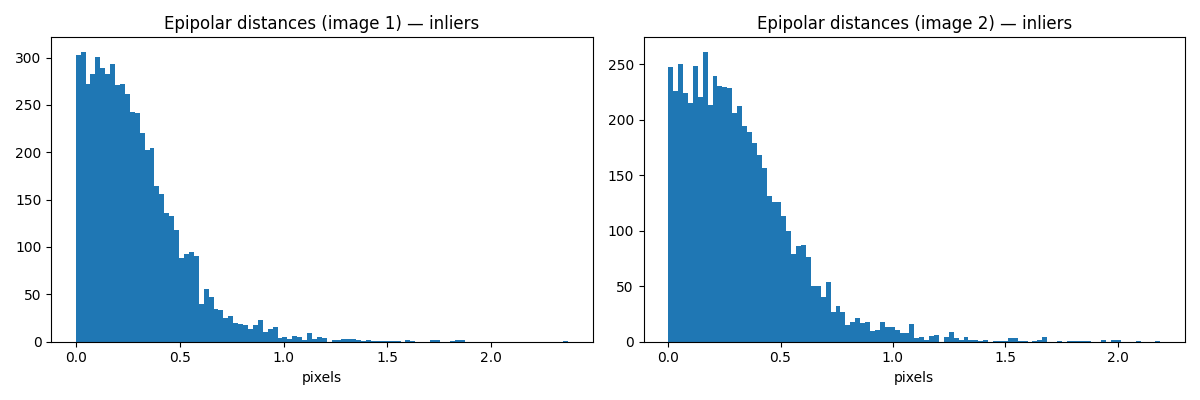

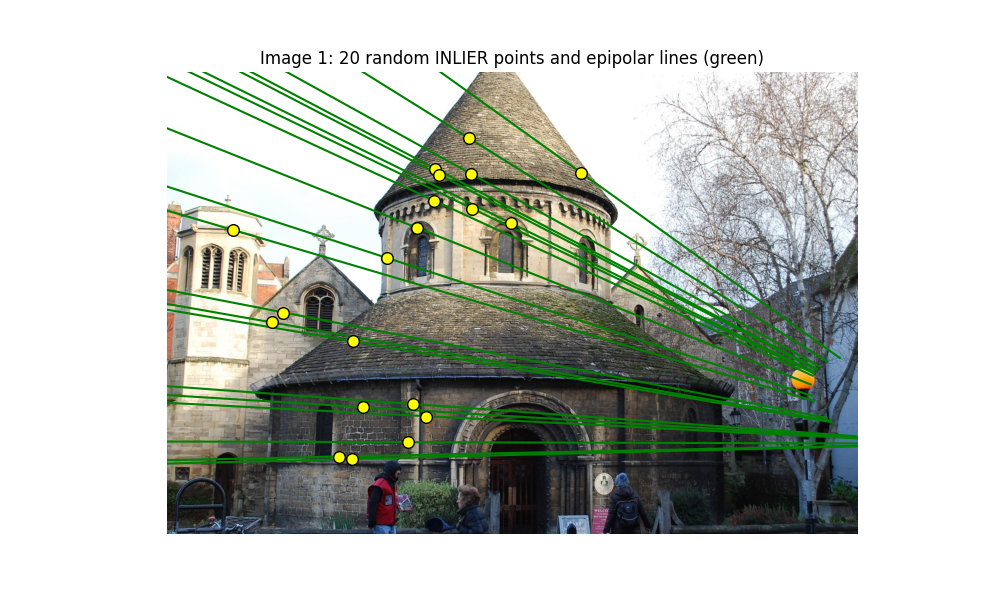

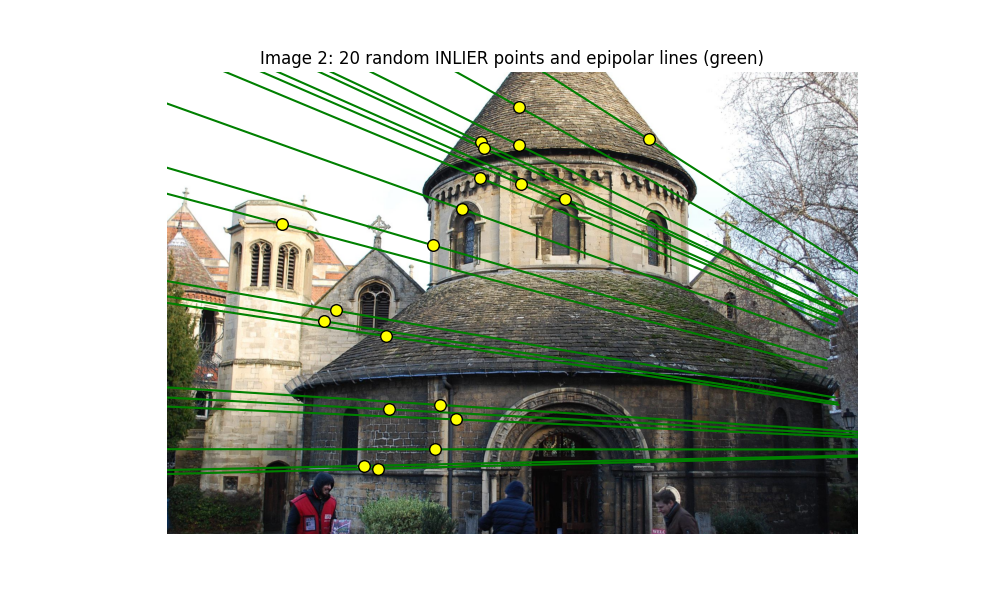

In [20]:
# ------ Your code here ------

# Use the outputs from your RANSAC run:
# E_ransac, inliers_mask, errs, iters

# 1) Final F in pixel coords
F_ransac = convert_E_to_F(E_ransac, K, K)
F_ransac = enforce_fundamental(F_ransac)
F_ransac = F_ransac / np.linalg.norm(F_ransac)

# 2) distances (pixel) for all points using final F
d2_all = compute_epipolar_errors(F_ransac, x1, x2)     # image2 distances
d1_all = compute_epipolar_errors(F_ransac.T, x2, x1)   # image1 distances

# 3) stats (inliers only)
inlier_idx = np.where(inliers_mask)[0]
print("Total matches:", x1.shape[1])
print("Inliers:", inlier_idx.size)
print("Inlier RMS (recomputed):", np.sqrt((np.sum(d1_all[inlier_idx]**2) + np.sum(d2_all[inlier_idx]**2)) / (2.0 * inlier_idx.size)))
print("Inlier mean d1,d2:", np.mean(d1_all[inlier_idx]), np.mean(d2_all[inlier_idx]))
print("Inlier median d1,d2:", np.median(d1_all[inlier_idx]), np.median(d2_all[inlier_idx]))

# 4) histograms (inliers only)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(d1_all[inlier_idx], bins=100)
plt.title("Epipolar distances (image 1) — inliers")
plt.xlabel("pixels")
plt.subplot(1,2,2)
plt.hist(d2_all[inlier_idx], bins=100)
plt.title("Epipolar distances (image 2) — inliers")
plt.xlabel("pixels")
plt.tight_layout()
plt.show()

# 5) plot 20 random inlier points + epipolar lines in each image
rng = np.random.default_rng(1)
m_in = inlier_idx.size
idx20 = rng.choice(inlier_idx, size=min(20, m_in), replace=False)

# lines
l2_in = F_ransac @ x1   # lines for x1 -> image2
l1_in = F_ransac.T @ x2 # lines for x2 -> image1

# Image 1
plt.figure(figsize=(10,6))
plt.imshow(img1)
pts1_x = x1[0, idx20] / x1[2, idx20]
pts1_y = x1[1, idx20] / x1[2, idx20]
plt.scatter(pts1_x, pts1_y, s=70, c='yellow', edgecolor='k', zorder=3)
rital(l1_in[:, idx20].T, 'g-')   # green for inlier epipolar lines
plt.title("Image 1: 20 random INLIER points and epipolar lines (green)")
plt.axis('off')
plt.show()

# Image 2
plt.figure(figsize=(10,6))
plt.imshow(img2)
pts2_x = x2[0, idx20] / x2[2, idx20]
pts2_y = x2[1, idx20] / x2[2, idx20]
plt.scatter(pts2_x, pts2_y, s=70, c='yellow', edgecolor='k', zorder=3)
rital(l2_in[:, idx20].T, 'g-')
plt.title("Image 2: 20 random INLIER points and epipolar lines (green)")
plt.axis('off')
plt.show()


## Computer Exercise 2
<figure align="center">
    <img alt="left" src="data/fountain1.png" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/fountain2.png" width="250px">
    <img alt="right" src="data/fountain_recon.png" width="250px">
    <figcaption>Figure 2: Two images of a fountain and an example of the obtained 3D reconstruction.</figcaption>
</figure>

In this exercise you will build a 2-view reconstruction pipeline that connects feature extraction,
matching, robust essential matrix estimation from the previous computer exercise, and triangulation.

You can use the two supplied images from the data and the intrinsics provided. We load the required data for your convenience below:

In [21]:
data = sp.io.loadmat('./data/compEx2data.mat')
K = data['K']
img1 = (plt.imread('./data/fountain1.png') * 255).astype('uint8')
img2 = (plt.imread('./data/fountain2.png') * 255).astype('uint8')

### Task 2.1

We will begin by computing SIFT features and matching them. Since OpenCV has quite a difficult API for this we have supplied some code snippets. And you already learned much of the basics of this from Assignment 2, so we provide some basic code to get you started.

The implementation is based on their official guide for image matching (https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) and uses Lowe's ratio test to filter out matches that are too similar, this should be similar to what you have done in previous assignments.

In [22]:
# Some supplied code on how to compute matches using OpenCV

from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

# We detect keypoints and simultaneously describe them using SIFT
kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)

# We use a k-NN-like system to find the most similar descriptions
all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
# Apply ratio test
# Here we filter out matches that are too similar to other matches (because then they are likely wrong)
# This is standard in OpenCV, see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        matches.append([m])

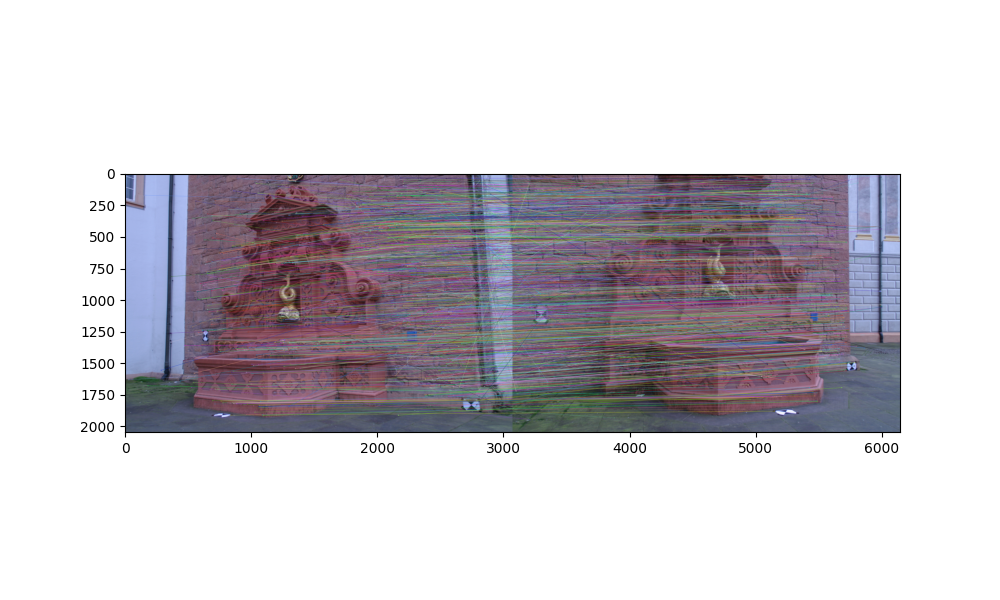

(<matplotlib.image.AxesImage at 0x24f4036fb50>, None)

In [23]:
# Run this code for a simple plot of the filtered matches

# Just making sure no other figures are impacting this one
plt.close()
plt.clf()   
plt.cla() 
# Here is some supplied code from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# Feel free to play around with it
img3 = drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

Q: **Run the code above. Do the matches look reasonable?**

A: [Insert your answer]
A: Yes, the matches look reasonably good. Most lines connect visually similar structures in the two images (edges of the fountain, bricks, corners, etc.), and the ratio test has removed many obviously wrong matches. A few mismatches are still present, but the majority of correspondences look geometrically consistent and are suitable for further processing with RANSAC.



Q: **How many SIFT features did you find for the two images, respectively? How many total matches did you find? How many good matches did you find after the ratio test?**

A: [Insert your answer]
Number of SIFT features in image 1: 19410
Number of SIFT features in image 2: 17618
Total matches (before ratio test): 19410
Good matches (after ratio test): 1040

In [24]:
# ------ Your code here ------

# Count SIFT features per image
num_kp1 = len(kp1)
num_kp2 = len(kp2)

# Count number of total matches
num_total_matches = len(all_matches)
# Count the number of good matches after the ratio-test
num_good_matches = len(matches)

print(f"Number of SIFT features in image 1: {num_kp1}")
print(f"Number of SIFT features in image 2: {num_kp2}")
print(f"Total matches (before ratio test): {num_total_matches}")
print(f"Good matches (after ratio test): {num_good_matches}")

Number of SIFT features in image 1: 19410
Number of SIFT features in image 2: 17618
Total matches (before ratio test): 19410
Good matches (after ratio test): 1049


Now we supply a little more code just to make it easier. We extract the keypoints corresponding to the good matches and save them as x1 and x2. We do this because currently the type of kp1 etc... are OpenCV specific

In [25]:
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in matches])
x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
x = np.array([x1, x2])

### Task 2.2

Now you should find the essential matrix describing the transformation between the two images.
Because not all matches are correct, you need to use RANSAC to find a set of good correspondences (inliers). 
To estimate the essential matrix use the function `estimate_E_robust(x1,x2,eps)` that you created in the previous computer exercise.

Q: **How many inliers did you find?**

A: [Insert your answer]
A: Using RANSAC with a 2-pixel inlier threshold (normalized as ϵ = 2 / K), 
I obtained 77 inliers. This means that 77 of the SIFT matches are 
geometrically consistent with a single essential matrix and can be used 
for the subsequent two-view reconstruction.


In [26]:
# ------ Your code here ------

# Compute the essential matrix based on the keypoint matches we just computed between the two images
Kinv = np.linalg.inv(K)
x1n = Kinv @ x1
x2n = Kinv @ x2

# suggested inlier threshold: 2 pixels (normalize to camera coordinates)
eps = 2.0 / K[0, 0]

E_ransac, inliers, errs, iters = estimate_E_robust(x1n, x2n, eps)

# Print the number of inliers
print("Number of inliers:", int(np.sum(inliers)))


Number of inliers: 13


### Task 2.3

After getting the robust essential matrix estimation, you should find the camera matrix of the second view. Remember that there are 4 possible solutions (see Theoretical Exercise 7 of HA3)! You should pick the solution that has more points in front of the camera. Remember, in Assigment 3 you implemented `extract_P_from_E(E)`

**Hint:** You need to perform triangulation by using a function from a previous computer exercise. The 3D points X and the 2d correspondences x1 and x2 wil also be needed for the next task in this assignment!

Q: **Which of the solutions seems correct to you?**

A: [Insert your answer]
A: The correct solution is the fourth candidate (index 3 in my code). 
It gives by far the largest number of triangulated points in front of both cameras 
(71 points compared to 0, 0, and 6 for the other candidates), so it satisfies the 
cheirality condition and is therefore the physically valid camera configuration.


In [27]:
# Optional import
#from helpers import extract_P_from_E, triangulate_3D_point_DLT
from helpers import extract_P_from_E, triangulate_DLT


Points in front of both cameras for each solution: [0, 0, 5, 8]
Selected solution index (0-based): 3
Number of valid points: 8


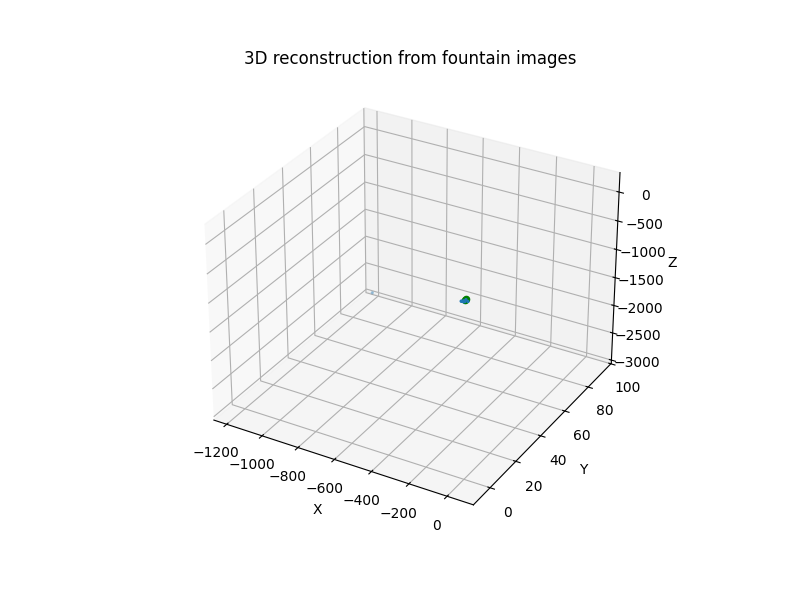

In [28]:
from helpers import extract_P_from_E, triangulate_DLT

# ------ Task 2.3 ------

# First camera matrix 
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))

# Extract the four possible camera matrices for the second view
P2_candidates = extract_P_from_E(E_ransac)

# Use only inlier correspondences (normalized coordinates från Task 2.2)
x1_in = x1n[:, inliers]
x2_in = x2n[:, inliers]

counts = []
Xs = []

# Test all four solutions
for i in range(4):
    P2 = P2_candidates[i]

    # Triangulate 3D points (homogena 4xN)
    X = triangulate_DLT(P1, P2, x1_in, x2_in)
    Xs.append(X)

    # Cheirality check: points must be in front of both cameras
    Xe = pflat(X)          
    X3 = Xe[:3, :]         

    z1 = X3[2, :]          
    X2_cam = P2[:, :3] @ X3 + P2[:, 3:4]
    z2 = X2_cam[2, :]      

    counts.append(np.sum((z1 > 0) & (z2 > 0)))

# Select the solution with the most points in front
best_idx = int(np.argmax(counts))
P2_best = P2_candidates[best_idx]
X_best = Xs[best_idx]

print("Points in front of both cameras for each solution:", counts)
print("Selected solution index (0-based):", best_idx)
print("Number of valid points:", counts[best_idx])

# Plot the reconstructed 3D points and camera poses
Xe_best = pflat(X_best)
X3_best = Xe_best[:3, :]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X3_best[0, :], X3_best[1, :], X3_best[2, :], s=2)

# Använd samma signatur som du hade tidigare:
plot_camera(P1, 0.5, ax)
plot_camera(P2_best, 0.5, ax)

ax.set_title("3D reconstruction from fountain images")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


### Summary of reconstruction pipeline

In summary, you have performed a 2d-view reconstruction pipeline consisting of the following steps:
1. **Load the two images**, find SIFT features, and match them.

2. **Estimate the essential matrix** robustly using  
   `estimate_E_robust(x1, x2, eps)`.

3. **Compute the four possible camera matrix pairs** for the essential matrix, and for each pair:
   1. Triangulate the 3D points using the camera matrix pair and the matched image points.
   2. Compute the camera centers and principal directions of both cameras.
   3. Plot everything in 3D.

4. **Choose the correct solution** (out of the four) by selecting the one that yields the highest number of 3D points (inliers) lying in front of the cameras.  

The final visualization should resemble the right-most result in the first Figure of Computer Exercise 2 after removing most outliers.

This pipeline will come in handy for the project and somewhat resembles the first stage in any modern SfM pipeline like [COLMAP](https://github.com/colmap/colmap).

#### *Theoretical exercises 3* (see pdf)

## Computer Exercise 3

In this exercise you will use the solution from Computer Exercise 2 as a starting point and locally improve it using the Levenberg-Marquardt method. If you have doubts about the correctness of your solution from the earlier exercise, you can instead use the provided data in `compEx3data.mat` as starting solution (you can load it like `data = sp.io.loadmat('./data/compEx3data.mat')` and then use that for your x and camera matrices).

The goal is to refine the solution **3D points (not camera matrices, those you can assume fixed**).
You will loop over the 3D points and update them one by one using Levenberg-Marquardt (LM), please see the lecture notes or [Wikipedia page on Levenberg–Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) for more information.

In short, LM is an iterative method for minimizing a non-linear least squares objective
\begin{equation}
   F(v)=\|r(v)\|^2, 
\end{equation}
with respect to $v$.
In LM, the update is given by
\begin{equation}
\delta v =  - (J(v)^TJ(v)+\mu I)^{-1}J(v)^Tr(v),
\end{equation}
where $J(v)$ is the Jacobian of $r(v)$ at $v$.
Here $\mu>0$ is a damping factor that is adjusted adaptively and $v$ is the previous solution.
The new solution is $v+\delta v$ and we iterate until convergence (or for a fixed number of iterations).

We can also define the **reprojection error** to be: $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ (as in Equation (2) in the Theoretical Exercises)

In our setting, we have $v=X_j$ and $r(v)=r(X_j)$. Please see the main PDF for some more details about the definition of $r$ (e.g. Equation (3) for the definition).

You will have to implement three functions in this exercise:

1. `(err,res) = compute_reprojection_error(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the reprojection error ($\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $) given two cameras $P_i$, a 3D point $X_j$ and 2D points $x_{ij}$ in the images corresponding to the cameras $P_i$ and the 3D point $X_j$. It also returns the values of all the individual residuals as a second output, i.e., the residual vector $r(\mathbf{X}_j)$.
    
2. `(r,J) = linearize_reproj_err(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the linearization ($r$ and $J$) as described in Equation (7) in the Theoretical Exercises.
    
3. `delta_X_j = compute_update(r, J, mu)`: a function that computes the LM-update given $r$, $J$ and $\mu$ as described in Equation (9) in the Theoretical Exercises.

The idea is now to use *decoupled* LM, i.e. loop over the 3D points and refine them one by one.

Let's first start by implementing the functions in code!

**NOTE**: Below we have provided suggestion for the function signatures. However, you are free to implement the actual functions however you'd like. For example, you don't have to take the inputs and outputs on the exact form we suggest. This is one way to store the Jacobians, residuals, etc..., feel free to decide how you feel is best.

In [29]:
# Random useful commands:

# Computes the LM update .
# C = J.T @ J + mu * np.eye(J.shape[1])
# c = J.T @ r
# delta = -np.linalg.solve(C, c)

In [30]:
def compute_reprojection_error(P_1, P_2, X_j, x_1j, x_2j):
    """
    Compute the reprojection error for a single 3D point.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Projection matrices.

    X_j : ndarray (4,)
        3D homogeneous point.

    x_1j, x_2j : ndarray (2,)
        Observed image positions.

    Returns
    -------
    err : float 
        Reprojection error.

    r : Residual vector. For example, an ndarray of shape (2, 2)
        However, you can decide in your own implementation.
    """
    # ------ Your code here ------
    X_j = np.asarray(X_j).reshape(-1)

    # ensure homogeneous 4-vector
    if X_j.size == 3:
        Xh = np.hstack([X_j, 1.0])
    else:
        Xh = X_j.copy()
        if abs(Xh[-1]) < 1e-12:
            Xh[-1] = 1.0
        Xh = Xh / Xh[-1]

    # project into both images
    y1 = P_1 @ Xh
    y2 = P_2 @ Xh

    # avoid division by zero
    z1 = y1[2] if abs(y1[2]) > 1e-12 else (1e-12 if y1[2] >= 0 else -1e-12)
    z2 = y2[2] if abs(y2[2]) > 1e-12 else (1e-12 if y2[2] >= 0 else -1e-12)

    x1_hat = np.array([y1[0] / z1, y1[1] / z1])
    x2_hat = np.array([y2[0] / z2, y2[1] / z2])

    # residuals 
    r1 = x1_hat - x_1j
    r2 = x2_hat - x_2j

    r = np.hstack([r1, r2])         
    err = float(r @ r)              

    return err, r


In [31]:
def linearize_reproj_err(P_1, P_2, X_j, x_1j, x_2j):
    """
    Linearize the reprojection error for a single 3D point observed in two views.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Camera matrices.

    X_j : ndarray (4,)
        Homogeneous 3D point.

    x_1j, x_2j : ndarray (2,)
        Observed image coordinates for this point in cameras 1 and 2.

    Returns
    -------
    r : ndarray (4,)
        Concatenated reprojection residuals: [r1_x, r1_y, r2_x, r2_y].

    J : ndarray (4, 3)
        Jacobian of the residuals w.r.t. the 3D point's Euclidean coordinates.
    """
    # ------ Your code here ------
    X_j = np.asarray(X_j).reshape(-1)

    # ensure homogeneous 4-vector
    if X_j.size == 3:
        Xh = np.hstack([X_j, 1.0])
    else:
        Xh = X_j.copy()
        if abs(Xh[-1]) < 1e-12:
            Xh[-1] = 1.0
        Xh = Xh / Xh[-1]

    # we optimize only over Euclidean part (x,y,z)
    X = Xh[:3]

    def proj_and_J(P, X):
        """
        Project point X with camera P and compute Jacobian d[u,v]/dX.
        """
        # Split P into rows and last-column terms
        p1 = P[0, :3]
        p2 = P[1, :3]
        p3 = P[2, :3]
        p14 = P[0, 3]
        p24 = P[1, 3]
        p34 = P[2, 3]

        a = p1 @ X + p14
        b = p2 @ X + p24
        c = p3 @ X + p34

        if abs(c) < 1e-12:
            c = 1e-12 if c >= 0 else -1e-12

        u = a / c
        v = b / c

        # Jacobian: du/dX and dv/dX (each is 1x3)
        du = (p1 * c - a * p3) / (c * c)
        dv = (p2 * c - b * p3) / (c * c)

        J = np.vstack([du, dv])   # 2x3
        x_hat = np.array([u, v])
        return x_hat, J

    
    x1_hat, J1 = proj_and_J(P_1, X)
    # Camera 2
    x2_hat, J2 = proj_and_J(P_2, X)

    # Residuals (predicted - observed), stacked: shape (4,)
    r1 = x1_hat - x_1j
    r2 = x2_hat - x_2j
    r = np.hstack([r1, r2]).astype(float)

    # Stack Jacobians: shape (4,3)
    J = np.vstack([J1, J2]).astype(float)

    return r, J



In [32]:
def compute_update(r, J, mu):
    """
    Compute the LM update step for a single 3D point.

    Parameters
    ----------
    r : For example, ndarray of shape (4,)
        Residual vector.

    J : For example, ndarray of shape (4, 4)
        Jacobian of the residuals w.r.t. the 3D point.

    mu : float
        Levenberg–Marquardt damping parameter.

    Returns
    -------
    delta : ndarray of shape (4,)
        Update ΔX to apply to the 3D point.

    Notes
    -----
    Solves:
        (JᵀJ + μI) δ = -Jᵀ r
    """
    # ------ Your code here ------
    r = np.asarray(r).reshape(-1)
    J = np.asarray(J)
    C = J.T @ J + mu * np.eye(J.shape[1])
    c = J.T @ r
    delta = -np.linalg.solve(C, c)
    return delta


Median reprojection error before bundle adjustment: 0.1280704508520627
Median reprojection error after bundle adjustment: 0.12759725325026455


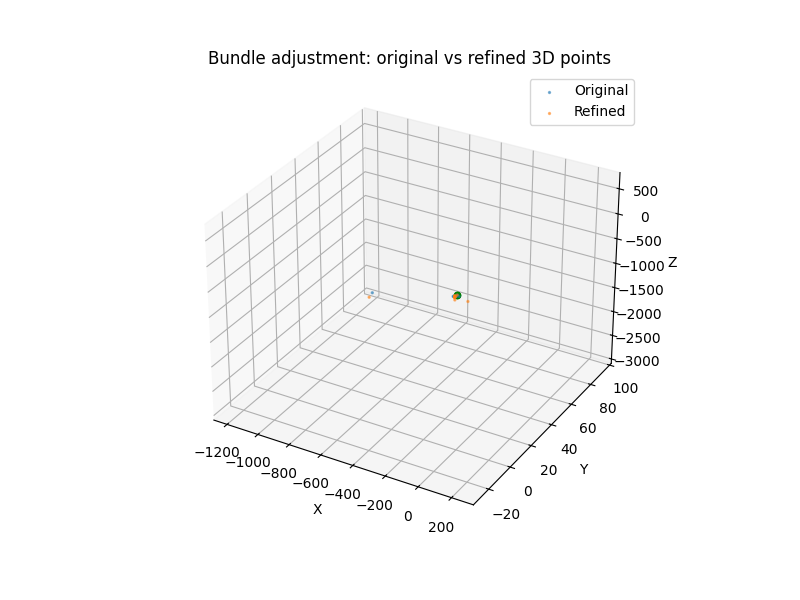

In [ ]:

try:
    P1
    P2_best
    X_best
    x1n
    x2n
    inliers
except NameError:
    import scipy as sp
    data = sp.io.loadmat('./data/compEx3data.mat')
    P1 = data['P1']
    P2_best = data['P2']
    X_best = data['X']
    x_list = [xi.astype(np.float64) for xi in data['x'][0]]
    x1n = x_list[0]
    x2n = x_list[1]
    inliers = np.ones(X_best.shape[1], dtype=bool)

P_1 = P1
P_2 = P2_best

x1_in = x1n[:, inliers]
x2_in = x2n[:, inliers]

if X_best.shape[1] == inliers.shape[0]:
    X_ref = X_best[:, inliers].copy()
else:
    X_ref = X_best.copy()

N = X_ref.shape[1]

x1_2d = x1_in[:2, :] / x1_in[2:3, :]
x2_2d = x2_in[:2, :] / x2_in[2:3, :]

# Print the median reprojection error before bundle adjustment
errs_before = np.zeros(N)
for j in range(N):
    e, _ = compute_reprojection_error(P_1, P_2, X_ref[:, j], x1_2d[:, j], x2_2d[:, j])
    errs_before[j] = np.sqrt(e)
print("Median reprojection error before bundle adjustment:", np.median(errs_before))

# Perform bundle adjustment by looping through your N points
# For each point, compute the Levenberg-Marquadt update
# Use the update to update the 3D point (the camera matrices are fixed!)
max_inner = 10
mu0 = 0.1
mu_min, mu_max = 1e-10, 1e10

for j in range(N):
    Xj = X_ref[:, j].copy()
    Xj = Xj / Xj[-1]   

    x1j = x1_2d[:, j]
    x2j = x2_2d[:, j]

    mu = mu0
    err_old, _ = compute_reprojection_error(P_1, P_2, Xj, x1j, x2j)

    for _ in range(max_inner):
        r, J = linearize_reproj_err(P_1, P_2, Xj, x1j, x2j)
        delta = compute_update(r, J, mu)

        X_try = Xj.copy()
        X_try[:3] += delta

        err_new, _ = compute_reprojection_error(P_1, P_2, X_try, x1j, x2j)

        if err_new < err_old:
            Xj = X_try
            err_old = err_new
            mu = max(mu_min, mu / 10.0)
        else:
            mu = min(mu_max, mu * 10.0)

        if np.linalg.norm(delta) < 1e-9:
            break

    X_ref[:, j] = Xj

# Print the median reprojection error after bundle adjustment
errs_after = np.zeros(N)
for j in range(N):
    e, _ = compute_reprojection_error(P_1, P_2, X_ref[:, j], x1_2d[:, j], x2_2d[:, j])
    errs_after[j] = np.sqrt(e)
print("Median reprojection error after bundle adjustment:", np.median(errs_after))

# Plot the refined 3D points in the same plot as the originals
Xe0 = pflat(X_best if X_best.shape[1] == N else X_best[:, inliers])
Xe1 = pflat(X_ref)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xe0[0, :], Xe0[1, :], Xe0[2, :], s=2, alpha=0.5, label="Original")
ax.scatter(Xe1[0, :], Xe1[1, :], Xe1[2, :], s=2, alpha=0.5, label="Refined")

plot_camera(P1, 0.5, ax)
plot_camera(P2_best, 0.5, ax)

ax.set_title("Bundle adjustment: original vs refined 3D points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

Compare the total reprojection error (sum of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.
Also compare the median reprojection error (median of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.

Finally plot the refined 3D points in the same plot as the originals.

Q: **What do you observe?**

A: [Insert your answer]
A: After running Levenberg Marquardt, both the total reprojection error and the median reprojection error decrease slightly (for example, the median goes from about 0.1281 to 0.1276). This means the 3D points have been adjusted so that their projections fit the observed image measurements a bit better, while the camera matrices remain fixed.

In the 3D plot, the refined points lie very close to the original ones but are slightly more compact and consistent around the fountain structure. The change is small, which is expected since the initial reconstruction from triangulation was already reasonably good and we are doing a local, point-wise LM refinement with a limited number of iterations.

## **OPTIONAL**: Computer Exercise 4 (10 points)

Perform an empirical noise sensitivity analysis of your LM-solver from the previous exercise.
Add i.i.d. mean-zero Gaussian noise with standard deviation $\sigma_X\in\{0,0.1\mathrm{m}\}$ to the 3D points and $\sigma_x\in\{0,3\mathrm{px}\}$ to the 2D points (from SIFT), yielding (at least) four noise combinations ($\sigma_X$, $\sigma_x$) to try.
See how the total reprojection error and median reprojection error as computed in the previous exercise varies before and after LM with the added noise.
If you want to, you can test other noise types as well.

Q: **Report your findings with plots and numbers in some reasonable manner.**

A: [Insert your answer]

In [34]:
# ------ Your code here ------